In [1]:
import os
from torch.utils.data import Dataset, DataLoader
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from tqdm.autonotebook import tqdm, trange
import torch.nn as nn
from torch.cuda import amp
import seaborn as sns

In [2]:
from torchvision import datasets, models, transforms

In [3]:
class TomatoDataset(Dataset):
    """Dataset Томатов"""
    
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.list_classes = list(sorted(os.listdir(root_dir)))
        self.img_path_list = []
        for one_class in self.list_classes:
            count_img = list(os.listdir(os.path.join(root_dir,
                                                     one_class)))
            for img in count_img:
                self.img_path_list.append(os.path.join(one_class,img))
        self.transform = transform
        self.img_list = np.empty([len(self.img_path_list), 256, 256, 3], dtype=np.uint8)
        for i, path in enumerate(self.img_path_list):
            self.img_list[i] = self.__get_img_by_path(os.path.join(root_dir, path))   
            
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        target = self.list_classes.index(os.path.dirname(self.img_path_list[index]))
        sample = {'image': self.img_list[index], 'target': target}
    
        if self.transform:
            sample["image"] = self.transform(self.img_list[index])
    
        return sample
    
    def __get_img_by_path(self, img_path):
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = np.array(img)
        return img

In [4]:
data = TomatoDataset("../dataset/train",transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.RandomResizedCrop(244),
                                    transforms.RandomHorizontalFlip(),
#                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#                                    Rescale(324),
                                  ]),)

In [5]:
data[0]['image'].to(torch.float16)

tensor([[[0.5449, 0.5459, 0.5479,  ..., 0.1323, 0.1069, 0.0941],
         [0.5449, 0.5459, 0.5479,  ..., 0.1375, 0.1064, 0.0909],
         [0.5449, 0.5459, 0.5479,  ..., 0.1454, 0.1061, 0.0865],
         ...,
         [0.4512, 0.4502, 0.4482,  ..., 0.2450, 0.2411, 0.2391],
         [0.4417, 0.4419, 0.4421,  ..., 0.2720, 0.2751, 0.2766],
         [0.4353, 0.4363, 0.4382,  ..., 0.2903, 0.2981, 0.3020]],

        [[0.5215, 0.5225, 0.5244,  ..., 0.2019, 0.1746, 0.1608],
         [0.5215, 0.5225, 0.5244,  ..., 0.2079, 0.1765, 0.1608],
         [0.5215, 0.5225, 0.5244,  ..., 0.2169, 0.1797, 0.1610],
         ...,
         [0.4275, 0.4265, 0.4246,  ..., 0.2284, 0.2225, 0.2196],
         [0.4182, 0.4182, 0.4187,  ..., 0.2537, 0.2559, 0.2571],
         [0.4119, 0.4128, 0.4148,  ..., 0.2705, 0.2783, 0.2825]],

        [[0.5293, 0.5303, 0.5322,  ..., 0.1372, 0.1059, 0.0902],
         [0.5293, 0.5303, 0.5322,  ..., 0.1428, 0.1067, 0.0886],
         [0.5293, 0.5303, 0.5322,  ..., 0.1514, 0.1082, 0.

In [6]:
def show_data(df):   
    fig = plt.figure(figsize=(13,13))


    for i in range(0,len(df),2000):
        sample = df[i]

        print(i, sample['image'].shape, sample['target'])
        i = int(i/2000)
        ax = plt.subplot(1, 4, i + 1)
        plt.tight_layout()
        ax.set_title('Sample {}'.format(i))
        ax.axis('off')
        plt.imshow(sample['image'].numpy().transpose((1, 2, 0)))
        if i == 3:
            plt.show()
            break


0 torch.Size([3, 244, 244]) 0
2000 torch.Size([3, 244, 244]) 1
4000 torch.Size([3, 244, 244]) 2
6000 torch.Size([3, 244, 244]) 3


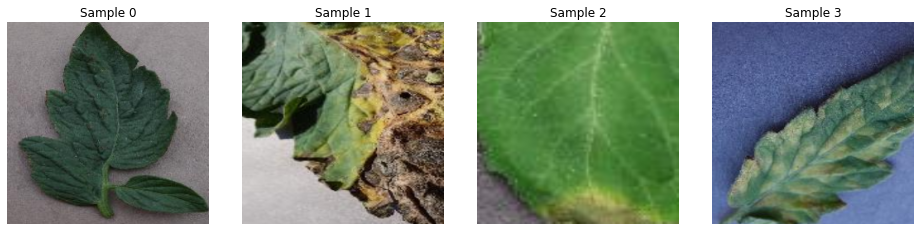

In [7]:
show_data(data)

In [8]:
valid = TomatoDataset("../dataset/valid", transform = transforms.Compose([transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(244),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                                                      ]))

0 torch.Size([3, 244, 244]) 0
2000 torch.Size([3, 244, 244]) 4
4000 torch.Size([3, 244, 244]) 8


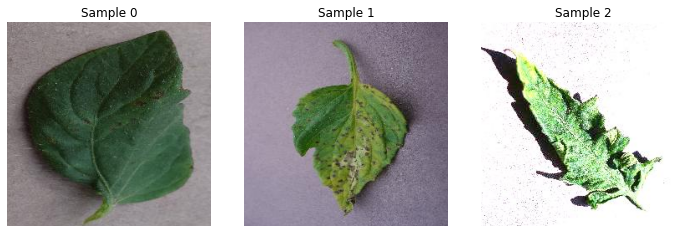

In [9]:
show_data(valid)

In [9]:
len(data)

18345

In [10]:
len(valid)

4585

In [11]:
data.list_classes

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [10]:
output_mapping = {
    0: 'Tomato___Bacterial_spot',
    1: 'Tomato___Early_blight',
    2: 'Tomato___Late_blight',
    3: 'Tomato___Leaf_Mold',
    4: 'Tomato___Septoria_leaf_spot',
    5: 'Tomato___Spider_mites Two-spotted_spider_mite',
    6: 'Tomato___Target_Spot',
    7: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    8: 'Tomato___Tomato_mosaic_virus',
    9: 'Tomato___healthy'
}

In [62]:
from collections import Counter
cnt_train = Counter([data[i]['target']for i in range(0,len(data))])

In [63]:
cnt_train

Counter({0: 1702,
         1: 1920,
         2: 1851,
         3: 1882,
         4: 1745,
         5: 1741,
         6: 1827,
         7: 1961,
         8: 1790,
         9: 1926})

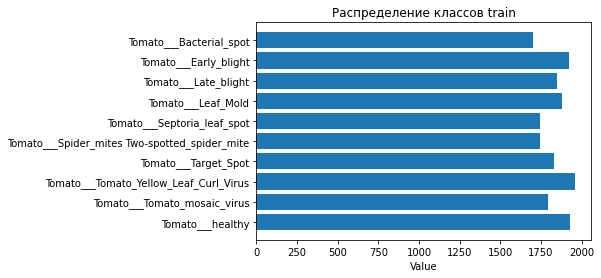

In [88]:
fig, ax = plt.subplots()
label = [output_mapping[j] for j in range(0,10)]
value = [cnt_train[j] for j in range(0,10)]
ax.barh(label, value, align='center')
ax.invert_yaxis()
# plt.bar(label, value)
# plt.xticks(rotation=90)
ax.set_xlabel('Value')
ax.set_title('Распределение классов train')
plt.show()

In [64]:
cnt_valid = Counter([valid[i]['target']for i in range(0,len(valid))])
cnt_valid

Counter({0: 425,
         1: 480,
         2: 463,
         3: 470,
         4: 436,
         5: 435,
         6: 457,
         7: 490,
         8: 448,
         9: 481})

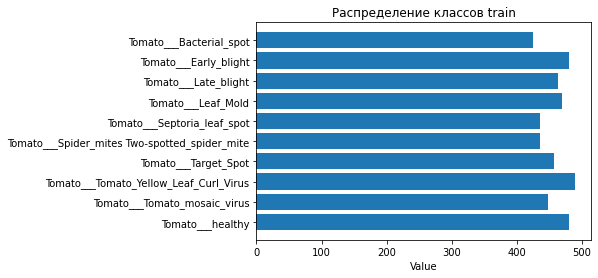

In [90]:
fig, ax = plt.subplots()
label = [output_mapping[j] for j in range(0,10)]
value = [cnt_valid[j] for j in range(0,10)]
ax.barh(label, value, align='center')
ax.invert_yaxis()
# plt.bar(label, value)
# plt.xticks(rotation=90)
ax.set_xlabel('Value')
ax.set_title('Распределение классов train')
plt.show()

In [11]:
train_dataloader = DataLoader(data, batch_size=6, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=6, shuffle=True)

In [12]:
image_datasets = {'train':data,
                  'val':valid}
dataloaders = {'train':train_dataloader,
               'val':valid_dataloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = output_mapping

In [13]:
use_gpu = torch.cuda.is_available()

In [60]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    #Ваш код здесь
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")
#     scaler = amp.GradScaler()
    num_epoch = 1
    for epoch in pbar:
        print("Epoch", num_epoch)
        num_epoch += 1
        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
               
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
#                 inputs = data['image'].half()
                inputs = data['image']
                labels = data['target']

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
#                 with amp.autocast(enabled=use_gpu):
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                    preds = torch.argmax(outputs, -1)
                    loss = criterion(outputs, labels)
                
                # backward pass + оптимизируем только если это стадия обучения
                
                if phase == 'train':
                    print(loss)
#                     scaler.scale(loss).backward()
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))
            
            print(phase)
            epoch_loss = running_loss / dataset_sizes[phase]
            print("epoch_loss", epoch_loss)
            epoch_acc = running_corrects / dataset_sizes[phase]
            print("epoch_acc", epoch_acc)
            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [20]:
torch.tensor([1.0], dtype=torch.float32).half().dtype

torch.float16

In [ ]:
# Ваш код здесь
model_extractor = models.vgg16(pretrained=True)

# замораживаем параметры (веса)
for param in model_extractor.features.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 10)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [80]:
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

Training complete in 65m 47s
Best val Acc: 0.695311


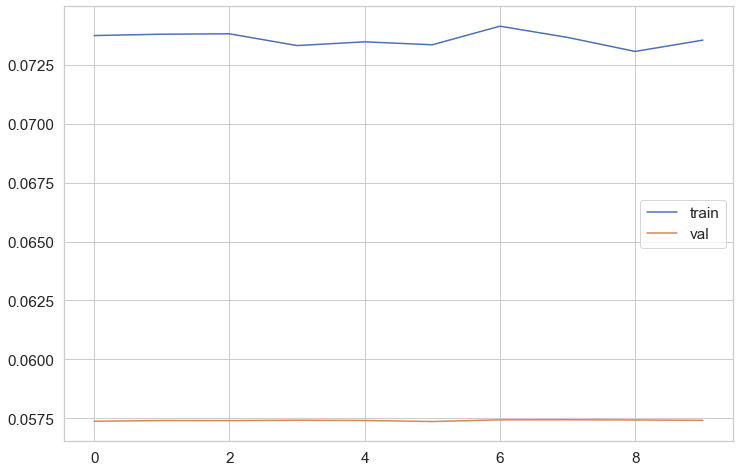

In [86]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(model_extractor.state_dict(), 'VGG16.pth')

In [97]:
# Ваш код здесь
model_mixed = models.vgg16(pretrained=True)

layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_mixed.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=num_features, out_features=1024, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=1024, out_features=10, bias=True),
  )

# Использовать ли GPU
if use_gpu:
    model_mixed = model_mixed.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = optim.Adam(list(model_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_mixed.classifier.parameters()), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [98]:
model_mixed, losses_mixed = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

2.354210615158081
2.2286758422851562
2.155904769897461
2.3546478748321533
2.2069969177246094
2.3851897716522217
2.0615334510803223
2.244455337524414
2.4127719402313232
2.680307149887085
2.2445743083953857
2.54831862449646
2.6428353786468506
2.191058874130249
2.4777562618255615
2.3899457454681396
2.006416082382202
2.329430103302002
2.266172409057617
1.9168895483016968
2.163278341293335
2.584775447845459
2.6024303436279297
2.79778790473938
2.2279882431030273
2.1246442794799805
2.589156150817871
2.245332956314087
2.3891382217407227
2.2433865070343018
2.165418863296509
2.3461029529571533
2.278987169265747
2.2908430099487305
2.2392632961273193
2.446016550064087
2.6258139610290527
2.6948604583740234
2.3319900035858154
2.1158580780029297
2.634080171585083
2.488247871398926
1.9420050382614136
2.465775728225708
2.2626993656158447
2.1349000930786133
2.192002058029175


KeyboardInterrupt: 

In [21]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
resnet18.models

AttributeError: 'ResNet' object has no attribute 'models'

In [22]:
resnet18 = models.resnet18(pretrained=True)
# layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet18.parameters():
    param.requires_grad = False
#разморозили три слоя слой  
for param in resnet18.layer2.parameters():
    param.requires_grad = True
for param in resnet18.layer3.parameters():
    param.requires_grad = True
for param in resnet18.layer4.parameters():
    param.requires_grad = True
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
resnet18.fc = nn.Linear(in_features=num_features, out_features=10, bias=True)

# Использовать ли GPU
if use_gpu:
    resnet18 = resnet18.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = optim.Adam(list(resnet18.layer2.parameters()) + 
                       list(resnet18.layer3.parameters()) +
                       list(resnet18.layer4.parameters()) +
                       list(resnet18.fc.parameters()), lr=0.01)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [23]:
resnet18, losses_mixed = train_model(resnet18, loss_fn, optimizer, exp_lr_scheduler, num_epochs=6)

Epoch::   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 0.6354109901470851
epoch_acc 0.10771327337149086


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 1.6353148819966041
epoch_acc 0.12780806979280263
Epoch 2


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 0.633494754668054
epoch_acc 0.10962115017716


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 1.4710351284873655
epoch_acc 0.13042529989094875
Epoch 3


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 0.6368096893832481
epoch_acc 0.10929408558190243


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 1.2805988697085282
epoch_acc 0.1282442748091603
Epoch 4


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 0.6416937425631078
epoch_acc 0.1086399563913873


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 1.7808610033442955
epoch_acc 0.1302071973827699
Epoch 5


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 0.6369491820960514
epoch_acc 0.10940310711365495


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 1.558682123681321
epoch_acc 0.12780806979280263
Epoch 6


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 0.6364941816883601
epoch_acc 0.10907604251839738


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 1.6424510660972305
epoch_acc 0.12017448200654307
Training complete in 21m 46s
Best val Acc: 0.130425


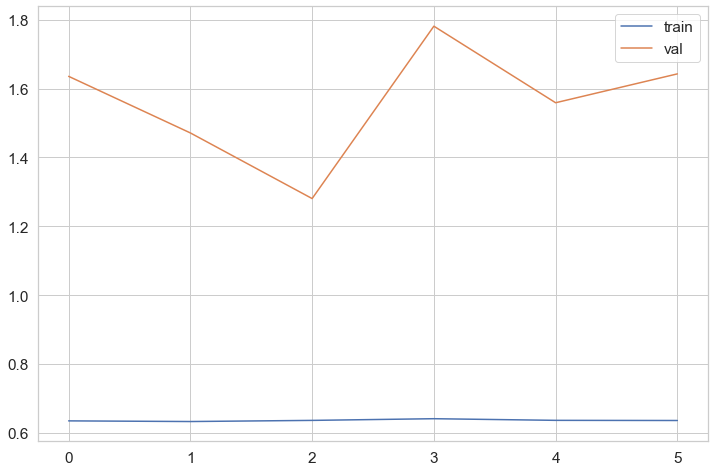

In [25]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses_mixed['train'], label="train")
plt.plot(losses_mixed['val'], label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(resnet18.state_dict(), 'RN18.pth')

In [ ]:
model_inception = models.inception_v3()

In [26]:
model_efficient = models.efficientnet_b1(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-533bc792.pth" to C:\Users\89zaz/.cache\torch\hub\checkpoints\efficientnet_b1_rwightman-533bc792.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

In [27]:
model_efficient

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [21]:
model_efficient = models.efficientnet_b1()

# # Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_efficient.parameters():
    param.requires_grad = True
# for param in model_efficient.features[:-4].parameters():
#     param.requires_grad = False
# #разморозили один слой  
# for param in resnet18.conv1.parameters():
#     param.requires_grad = True
# for param in resnet18.bn1.parameters():
#     param.requires_grad = True
# for param in resnet18.layer4.parameters():
#     param.requires_grad = True

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 1280
# Заменяем Fully-Connected слой на наш линейный классификатор
model_efficient.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=False),
    nn.Linear(in_features=num_features, out_features=10, bias=True),
  )

# Использовать ли GPU
if use_gpu:
    model_efficient = model_efficient.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
# optimizer = optim.Adam(list(model_efficient.features.parameters())[-4:] + 
#                       list(model_efficient.classifier.parameters()), lr=0.01)
optimizer = optim.Adam(model_efficient.parameters(), lr=0.05)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [22]:
model_efficient, losses_efficient = train_model(model_efficient, loss_fn, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 1.175796684490364
epoch_acc 0.1101662578359226


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 0.8018317482073668
epoch_acc 0.10207197382769902
Epoch 2


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 1.1728670170860156
epoch_acc 0.10853093485963478


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 0.9300460569731152
epoch_acc 0.08375136314067612
Epoch 3


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 1.1833656306876315
epoch_acc 0.10853093485963478


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 0.8603265165892656
epoch_acc 0.09923664122137404
Epoch 4


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 1.18369200422641
epoch_acc 0.10798582720087217


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 0.8542531564945482
epoch_acc 0.09334787350054526
Epoch 5


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 1.177843771457802
epoch_acc 0.1119651131098392


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 0.9842684113732341
epoch_acc 0.1193020719738277
Epoch 6


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 1.1772784594295134
epoch_acc 0.11114745162169529


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 0.8799421997860708
epoch_acc 0.0935659760087241
Epoch 7


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 1.1827968413383378
epoch_acc 0.108367402562006


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 0.8856995275262398
epoch_acc 0.09792802617230098
Epoch 8


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 1.1926931541081052
epoch_acc 0.10951212864540746


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 0.7833997208783515
epoch_acc 0.10207197382769902
Epoch 9


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 1.1685449239635182
epoch_acc 0.10967566094303625


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 0.8748197016305206
epoch_acc 0.08702290076335878
Epoch 10


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses_efficient['train'], label="train")
plt.plot(losses_efficient['val'], label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(model_efficient.state_dict(), 'ENB3.pth')

In [ ]:
modelmy=Sequential([
                Conv2D(32,3,activation='relu',kernel_initializer='he_normal',input_shape=(Size,Size,3)),
                BatchNormalization(),
                MaxPooling2D(3),
    
                Conv2D(64,3,activation='relu',kernel_initializer='he_normal'),
                BatchNormalization(),
                MaxPooling2D(3),
    
                Conv2D(128,3,activation='relu',kernel_initializer='he_normal'),
                BatchNormalization(),
                MaxPooling2D(3),
    
                Conv2D(256,3,activation='relu',kernel_initializer='he_normal'),
                BatchNormalization(),
                MaxPooling2D(3),
#vgg19(include_top=False,input_shape=(Size,Size,3)),
                Flatten(),
                Dense(512,activation='relu'),
                BatchNormalization(),
                Dropout(0.2),
                BatchNormalization(),
                Dense(256,activation='relu'),
                Dropout(0.2),
                BatchNormalization(),
                Dense(38,activation='softmax')
])

In [23]:
model_alex = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\89zaz/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [24]:
model_alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
model_alex = models.alexnet(pretrained=True)

# # Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_alex.parameters():
    param.requires_grad = True

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_alex.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=num_features, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=10, bias=True),
  )

# Использовать ли GPU
if use_gpu:
    model_alex = model_alex.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_alex.parameters(), lr=0.05)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [27]:
model_alex, losses_alex = train_model(model_alex, loss_fn, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 86114.67377402785
epoch_acc 0.101880621422731


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 11651.487320874796
epoch_acc 0.09094874591057797
Epoch 2


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 11749.915041657618
epoch_acc 0.10346143363314254


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 11651.663615645448
epoch_acc 0.09094874591057797
Epoch 3


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 11746.804376099264
epoch_acc 0.10384300899427637


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 11658.693780297932
epoch_acc 0.09094874591057797
Epoch 4


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 11742.306196234498
epoch_acc 0.10433360588716271


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 11654.548688935558
epoch_acc 0.09094874591057797
Epoch 5


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 11738.724800934562
epoch_acc 0.1000817661488144


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 11660.865185244029
epoch_acc 0.09094874591057797
Epoch 6


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 11795.073882542607
epoch_acc 0.10013627691469065


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 11683.62858431451
epoch_acc 0.09094874591057797
Epoch 7


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 11763.090639319722
epoch_acc 0.10564186426819297


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 11652.036523863482
epoch_acc 0.09094874591057797
Epoch 8


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 11770.130941972917
epoch_acc 0.10029980921231943


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 11672.307640296995
epoch_acc 0.09094874591057797
Epoch 9


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 11766.161329588913
epoch_acc 0.10395203052602889


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 11677.823707359255
epoch_acc 0.09094874591057797
Epoch 10


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 11748.153782323181
epoch_acc 0.10400654129190515


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 11654.766696556366
epoch_acc 0.09094874591057797
Epoch 11


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 11739.163016202048
epoch_acc 0.10438811665303897


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 11659.47524238345
epoch_acc 0.09094874591057797
Epoch 12


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 11762.133488933889
epoch_acc 0.10046334150994822


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 11660.070894497172
epoch_acc 0.09094874591057797
Epoch 13


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

train
epoch_loss 11801.075289481978
epoch_acc 0.10057236304170074


val iter::   0%|          | 0/765 [00:00<?, ?it/s]

val
epoch_loss 11659.718965227134
epoch_acc 0.09094874591057797
Epoch 14


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses_alex['train'], label="train")
plt.plot(losses_alex['val'], label="val")
plt.legend()
plt.show()

In [62]:
# model1 = Model1().half()
model1 = Model1()

# Использовать ли GPU
if use_gpu:
    model1 = model1.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
# optimizer = optim.Adam(list(model_efficient.features.parameters())[-4:] + 
#                       list(model_efficient.classifier.parameters()), lr=0.01)
optimizer = optim.Adam(model1.parameters(), lr=0.05)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [63]:
model1, losses_model1 = train_model(model1, loss_fn, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

2.2237660884857178
4.110694408416748
6.9988179206848145
2.387272596359253
13.6303071975708
6.907388210296631
10.149144172668457
13.644282341003418
13.304393768310547
7.829355239868164
3.982625722885132
6.956226348876953
3.707919120788574
5.5075297355651855
5.467555522918701
2.767681360244751
7.739070892333984
3.233517646789551
1.8141587972640991
2.58955454826355
4.630642414093018
2.1545066833496094
4.602802753448486
3.046064615249634
4.699141025543213
4.9491143226623535
4.046300888061523
3.1016857624053955
4.611992835998535
3.9608993530273438
1.7934640645980835
2.5860378742218018
3.3428122997283936
3.590709924697876
3.536107301712036
3.4817092418670654
2.4964005947113037
3.7209737300872803
2.0950329303741455
3.223215341567993
3.799875259399414
3.086796522140503
3.601818323135376
5.760562896728516
2.134570360183716
4.713651180267334
2.5529348850250244
4.484248638153076
3.3146324157714844
3.240823745727539
3.546010971069336
4.649596214294434
3.9076690673828125
3.2399609088897705
6.594331

KeyboardInterrupt: 

In [ ]:
sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses_alex['train'], label="train")
plt.plot(losses_alex['val'], label="val")
plt.legend()
plt.show()

In [13]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    val_losses = []
    valid_accuracies = []
    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        for target in tqdm(train_dl):
            xb, yb = target['image'].to(device), target['target'].to(device)
            loss = loss_func(model(xb), yb)
            loss_sum += loss.item()
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses.append(loss_sum / len(train_dl))

        model.eval()
        loss_sum = 0
        correct = 0
        num = 0
        with torch.no_grad():
            for target in tqdm(valid_dl):
                xb, yb = target['image'].to(device), target['target'].to(device)
                
                probs = model(xb)
                loss_sum += loss_func(probs, yb).item()
                
                _, preds = torch.max(probs, axis=-1)
                correct += (preds == yb).sum().item()
                num += len(xb)
                
        val_losses.append(loss_sum / len(valid_dl))
        valid_accuracies.append(correct / num)
        
    return train_losses, val_losses, valid_accuracies

In [17]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 5, stride = 2, padding = 1)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(6272, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.bn1(nn.functional.max_pool2d(nn.functional.relu(self.conv1(x)), 2))
        x = self.bn2(nn.functional.max_pool2d(nn.functional.relu(self.conv2(x)), 2))
        x = self.bn3(nn.functional.max_pool2d(nn.functional.relu(self.conv3(x)), 2))
        x = x.view(x.shape[0], -1)
        x = self.bn4(nn.functional.relu(self.fc1(x)))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
def plot_trainig(train_losses, valid_losses, valid_accuracies):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(train_losses, label="train_loss")
    plt.plot(valid_losses, label="valid_loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()

In [19]:
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
device

device(type='cuda')

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

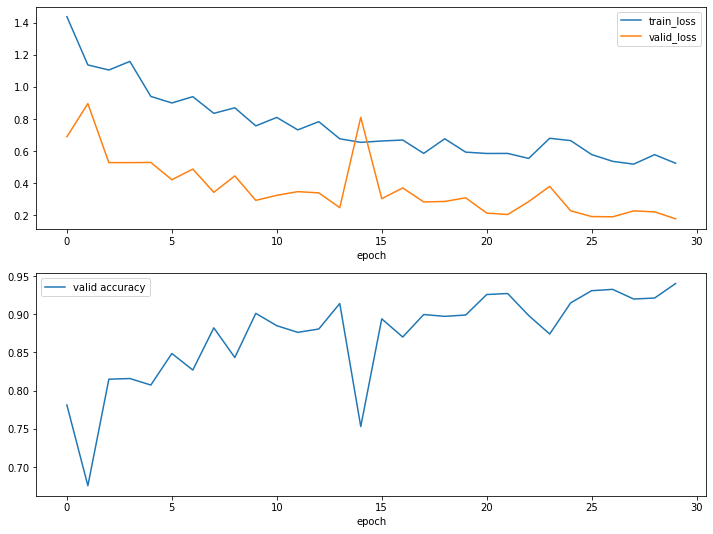

In [20]:
model1 = Model1().to(device)
loss_fn1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

info1 = fit(30, model1, loss_fn1, optimizer1, train_dataloader, valid_dataloader)
plot_trainig(*info1)

In [21]:
torch.save(model1.state_dict(), 'Model1.pth')

In [22]:
info1[2][-1]

0.9317339149400218

In [31]:
test = TomatoDataset("../dataset/test",transform = transforms.Compose([transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(244)]))

In [32]:
test_dl = DataLoader(test, batch_size=6, shuffle=True)

In [37]:
test_accuracies = []
model = model1
model.eval()
correct = 0
num = 0
with torch.no_grad():
    for target in tqdm(test_dl):
        xb, yb = target['image'].to(device), target['target'].to(device)

        probs = model(xb)

        _, preds = torch.max(probs, axis=-1)
        correct += (preds == yb).sum().item()
        num += len(xb)

test_accuracies.append(correct / num)

  0%|          | 0/3 [00:00<?, ?it/s]

In [38]:
print("accuracies:",test_accuracies)

accuracies: [0.125]


In [44]:
resnet18_two = models.resnet18(pretrained=True)
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet18_two.parameters():
    param.requires_grad = False

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet18_two.parameters():
    param.requires_grad = False
#разморозили три слоя слой  
for param in resnet18_two.layer2.parameters():
    param.requires_grad = True
for param in resnet18_two.layer3.parameters():
    param.requires_grad = True
for param in resnet18_two.layer4.parameters():
    param.requires_grad = True    
    
resnet18_two.fc = nn.Linear(in_features=512, out_features=10, bias=True)
    
resnet18_two = resnet18_two.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(resnet18_two.layer2.parameters()) + 
                       list(resnet18_two.layer3.parameters()) +
                       list(resnet18_two.layer4.parameters()) +
                       list(resnet18_two.fc.parameters()), lr=0.01)

resnet18_two_inf = fit(30,resnet18_two, loss_fn, optimizer, train_dataloader,valid_dataloader)
plot_trainig(*resnet18_two_inf)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.